In [4]:
import torch                        # The core package of Torch
import torch.nn as nn               # The nn package is used for building neural networks
import torch.nn.functional as F     # Contains all the functions in the torch.nn library
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
import scikitplot as skplt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Code Reference: https://www.kaggle.com/code/demidova/handwritten-digit-recognition-with-pytorch-fnn/notebook#3.-Prepare-data

In [11]:
# read data
train_data = pd.read_csv('C:/Users/joisr/CSE676/archive/mnist_train.csv') #replace path with correct path
test = pd.read_csv('C:/Users/joisr/CSE676/archive/mnist_test.csv') #replace path with correct path

# check that we loaded data correctly
print("Train data shape:", train_data.shape)
print("Test data shape:", test.shape)

Train data shape: (60000, 785)
Test data shape: (10000, 785)


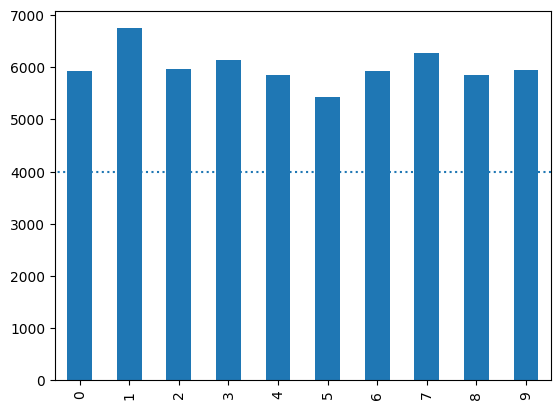

In [12]:
label_counts  = train_data["label"].value_counts().sort_index()
label_counts.plot.bar()
plt.hlines(xmin = -1, xmax = 10, y = 4000, linestyles='dotted')

In [13]:
train_all = train_data.iloc[:,1:]     # only features (pixels)
train_all_label = train_data["label"] # labels

# convert to numpy array
train_all_numpy = train_all.to_numpy()
train_all_label_numpy = train_all_label.to_numpy()
test_numpy = test.to_numpy()

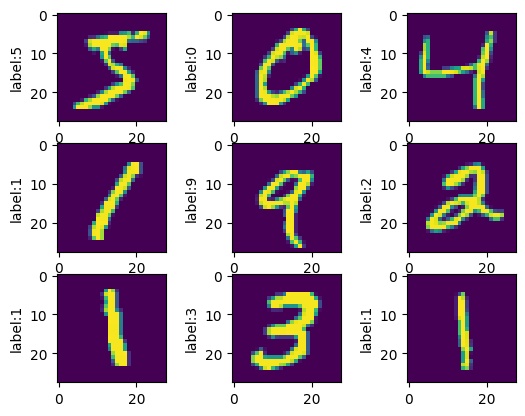

In [15]:
def plot_img(data, label):
    fig, axs = plt.subplots(3, 3) # 9 images
    k = 0
    for i in range(3):
        for j in range(3):        
            axs[i, j].imshow(data[k].astype('uint8').reshape(28, 28))   # plot image            
            axs[i, j].set_ylabel("label:" + str(label[k].item()))       # print label
            k +=1
plot_img(train_all_numpy, train_all_label_numpy)

In [16]:
# split train on train and validation
train, validation, train_label, validation_label = train_test_split(train_all_numpy, train_all_label_numpy, test_size=0.2)

print(train.shape)
print(train_label.shape)
print(validation.shape)
print(validation_label.shape)

(48000, 784)
(48000,)
(12000, 784)
(12000,)


<BarContainer object of 10 artists>

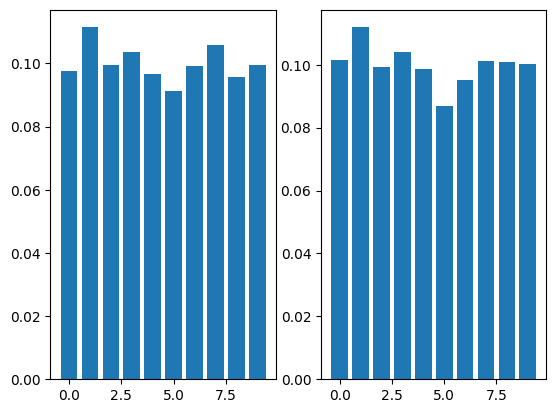

In [32]:
unique, counts_train = np.unique(train_label, return_counts=True)
plt.subplot(1, 2, 1)
plt.bar(unique, counts_train/len(train_label))
unique, counts_val = np.unique(validation_label, return_counts=True)
plt.subplot(1, 2, 2)
plt.bar(unique, counts_val/len(validation_label))
#print (np.asarray((unique, counts_train/len(train_label), counts_val/len(validation_label))).T)

In [33]:
train_all_tensor = torch.as_tensor(train_all_numpy).type(torch.FloatTensor)
train_all_label_tensor = torch.as_tensor(train_all_label_numpy)
test_tensor = torch.as_tensor(test_numpy).type(torch.FloatTensor)

train_tensor = torch.as_tensor(train).type(torch.FloatTensor)
train_label = torch.as_tensor(train_label)

validation_tensor = torch.as_tensor(validation).type(torch.FloatTensor)
validation_label = torch.as_tensor(validation_label)

In [34]:
                   # nn.Module - Base class for all neural network modules.
class FNet(nn.Module):             
    def __init__(self):
        super(FNet, self).__init__()
                   # 784 inputs, connects to hidden layer with 600 nodes
        self.fc1 = nn.Linear(in_features=784, out_features=600)
                   # 600 nodes connects to hidden layer with 500 nodes
        self.fc2 = nn.Linear(in_features=600, out_features=500) 
                   # 500 nodes connects to hidden layer with 250 nodes
        self.fc3 = nn.Linear(in_features=500, out_features=250) 
                   # connection between the last hidden layer 
                   # and the output layer (with 10 nodes)
        self.fc4 = nn.Linear(in_features=250, out_features=10)  
                                                                
    def forward(self, x):
        x = x.view(-1,784)          # Put all the entries of the image in the vector
        x = F.relu(self.fc1(x))     # Input x into first layer and apply a ReLU
                                    # to the nodes in this layer
        x = F.relu(self.fc2(x))        
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x     

In [35]:
def get_accuracy(predictions, true_labels):
    _, predicted = torch.max(predictions, 1)
    corrects = (predicted == true_labels).sum()
    accuracy = 100.0 * corrects/len(true_labels)
    return accuracy.item()

In [36]:
def training (dataloader, epochs, model, criterion, optimizer):

    train_accuracies, train_losses = [], []
    
    # set the train mode
    model.train()
    
    # loop over training dataset multiple times
    for epoch in range(epochs):        

        train_loss = 0 
        train_accuracy = 0
        num_batch = 0
        
        # iterate over all batches
        for data, labels in dataloader:
            
            # zero the parameters gradient to not accumulate gradients from previous iteration
            optimizer.zero_grad()
            
            # put data into the model
            predictions = net(data)
            
            # calculate loss
            loss = criterion(predictions, labels)
            
            # calculate accuracy
            accurasy = get_accuracy(predictions, labels)
            
            # compute gradients
            loss.backward()
            
            # change the weights
            optimizer.step()
            
            num_batch += 1
            train_loss += loss.item()
            train_accuracy += accurasy
    
        epoch_accuracy = train_accuracy/num_batch
        epoch_loss = train_loss/num_batch        
        train_accuracies.append(epoch_accuracy)
        train_losses.append(epoch_loss)
        
        print("Epoch: {}/{} ".format(epoch + 1, epochs),
              "Training Loss: {:.4f} ".format(epoch_loss),
              "Training accuracy: {:.4f}".format(epoch_accuracy))
    
    return train_accuracies, train_losses

In [37]:
torch.manual_seed(0)                                      # set seed to make results reproducible

batch_size = 128                                          # Set the batch_size
train_dataset = torch.utils.data.TensorDataset(train_tensor, train_label)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)


epochs = 40                                               # set number of epohs

net = FNet()                                              # initialize network
criterion = nn.CrossEntropyLoss()                         # set criterion
optimizer = torch.optim.Adam(net.parameters(), lr = 3e-4) # set optimizer

                                                          # start training process
train_accuracies, train_losses = training(trainloader, epochs, net, criterion, optimizer)

Epoch: 1/40  Training Loss: 0.3025  Training accuracy: 91.3647
Epoch: 2/40  Training Loss: 0.0936  Training accuracy: 97.1394
Epoch: 3/40  Training Loss: 0.0530  Training accuracy: 98.3157
Epoch: 4/40  Training Loss: 0.0380  Training accuracy: 98.7999
Epoch: 5/40  Training Loss: 0.0272  Training accuracy: 99.1356
Epoch: 6/40  Training Loss: 0.0333  Training accuracy: 98.8653
Epoch: 7/40  Training Loss: 0.0211  Training accuracy: 99.2425
Epoch: 8/40  Training Loss: 0.0219  Training accuracy: 99.2425
Epoch: 9/40  Training Loss: 0.0268  Training accuracy: 99.1088
Epoch: 10/40  Training Loss: 0.0188  Training accuracy: 99.3940
Epoch: 11/40  Training Loss: 0.0208  Training accuracy: 99.3940
Epoch: 12/40  Training Loss: 0.0164  Training accuracy: 99.4564
Epoch: 13/40  Training Loss: 0.0155  Training accuracy: 99.4861
Epoch: 14/40  Training Loss: 0.0175  Training accuracy: 99.4356
Epoch: 15/40  Training Loss: 0.0217  Training accuracy: 99.3197
Epoch: 16/40  Training Loss: 0.0198  Training acc

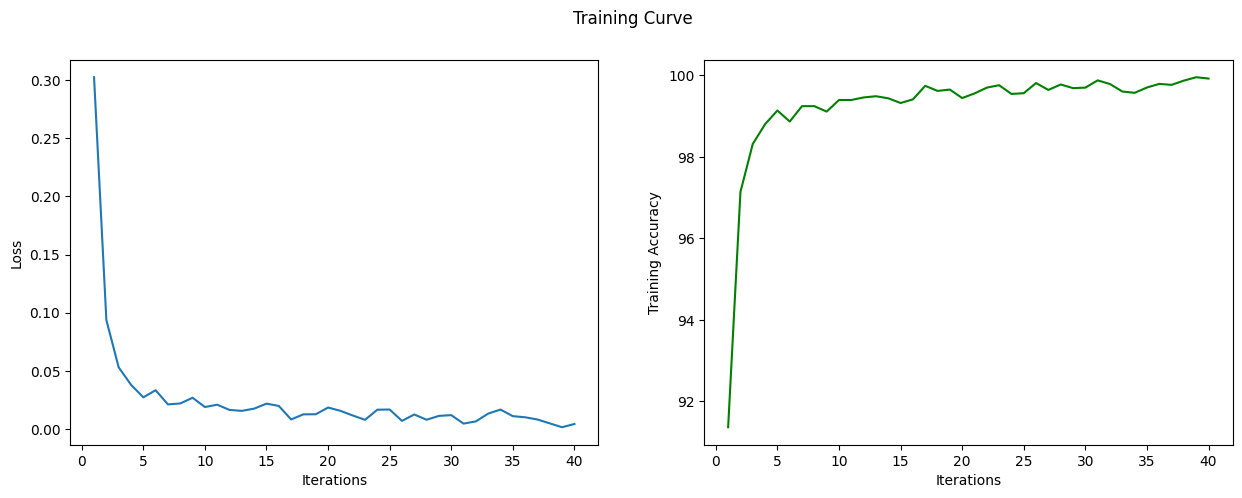

In [38]:
def train_curves(epochs, train_losses, train_accuracies):
    iters = range(1, epochs+1)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
    fig.suptitle('Training Curve')
    ax1.plot(iters, train_losses)
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax2.plot(iters, train_accuracies, color = 'g')
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Training Accuracy")
    plt.show()
    
train_curves(epochs, train_losses, train_accuracies)

Loss:  0.1399477869272232 Accuracy:  98.05952453613281


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

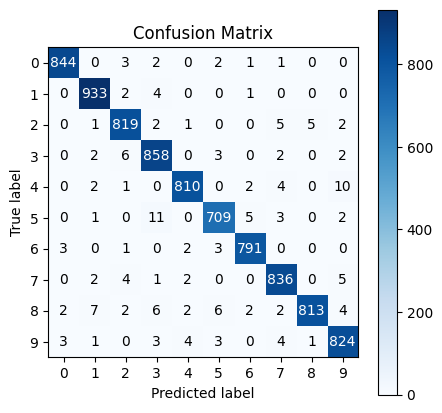

In [39]:
# set net in test (evaluation) mode
net.eval()    
# get predictions
val_predictions = net(validation_tensor)
val_loss = criterion(val_predictions, validation_label)
val_accurasy = get_accuracy(val_predictions, validation_label)
 
print("Loss: ", str(val_loss.item()), "Accuracy: ", str(val_accurasy))

# to get class with the maximum score as prediction
_, val_predicted = torch.max(val_predictions.data,1)            

# confusion matrix
skplt.metrics.plot_confusion_matrix(validation_label, val_predicted, figsize=(5,5))

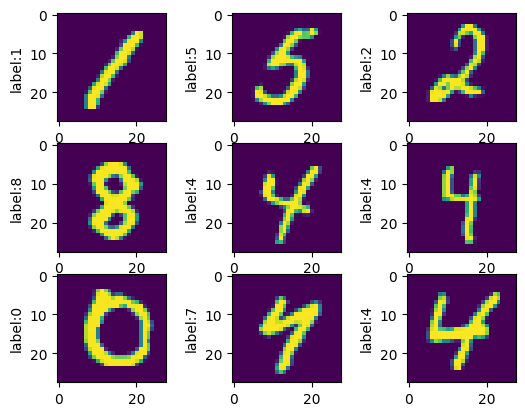

In [40]:
plot_img(validation, val_predicted)

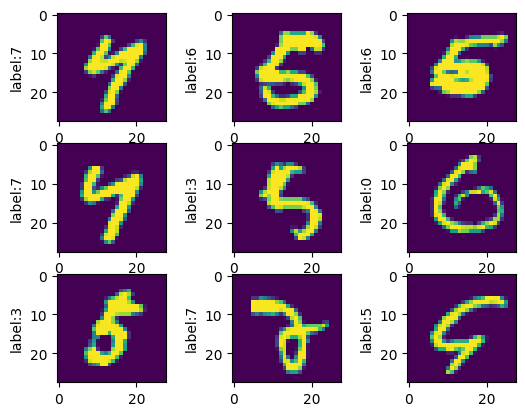

In [41]:
# wrong predicted

val_wrong = validation[validation_label != val_predicted]
val_lab_wrong = val_predicted[validation_label != val_predicted]

plot_img(val_wrong, val_lab_wrong)

In [42]:
torch.manual_seed(0)                                      # set seed to make results reproducible

batch_size = 128                                          # Set the batch_size
train_all_dataset = torch.utils.data.TensorDataset(train_all_tensor, train_all_label_tensor)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

epochs = 40                                               # set number of epohs

net = FNet()                                              # initialize network
criterion = nn.CrossEntropyLoss()                         # set criterion
optimizer = torch.optim.Adam(net.parameters(), lr = 3e-4) # set optimizer

                                                          # start training process
train_accuracies, train_losses = training(trainloader, epochs, net, criterion, optimizer)

Epoch: 1/40  Training Loss: 0.3025  Training accuracy: 91.3647
Epoch: 2/40  Training Loss: 0.0936  Training accuracy: 97.1394
Epoch: 3/40  Training Loss: 0.0530  Training accuracy: 98.3157
Epoch: 4/40  Training Loss: 0.0380  Training accuracy: 98.7999
Epoch: 5/40  Training Loss: 0.0272  Training accuracy: 99.1356
Epoch: 6/40  Training Loss: 0.0333  Training accuracy: 98.8653
Epoch: 7/40  Training Loss: 0.0211  Training accuracy: 99.2425
Epoch: 8/40  Training Loss: 0.0219  Training accuracy: 99.2425
Epoch: 9/40  Training Loss: 0.0268  Training accuracy: 99.1088
Epoch: 10/40  Training Loss: 0.0188  Training accuracy: 99.3940
Epoch: 11/40  Training Loss: 0.0208  Training accuracy: 99.3940
Epoch: 12/40  Training Loss: 0.0164  Training accuracy: 99.4564
Epoch: 13/40  Training Loss: 0.0155  Training accuracy: 99.4861
Epoch: 14/40  Training Loss: 0.0175  Training accuracy: 99.4356
Epoch: 15/40  Training Loss: 0.0217  Training accuracy: 99.3197
Epoch: 16/40  Training Loss: 0.0198  Training acc

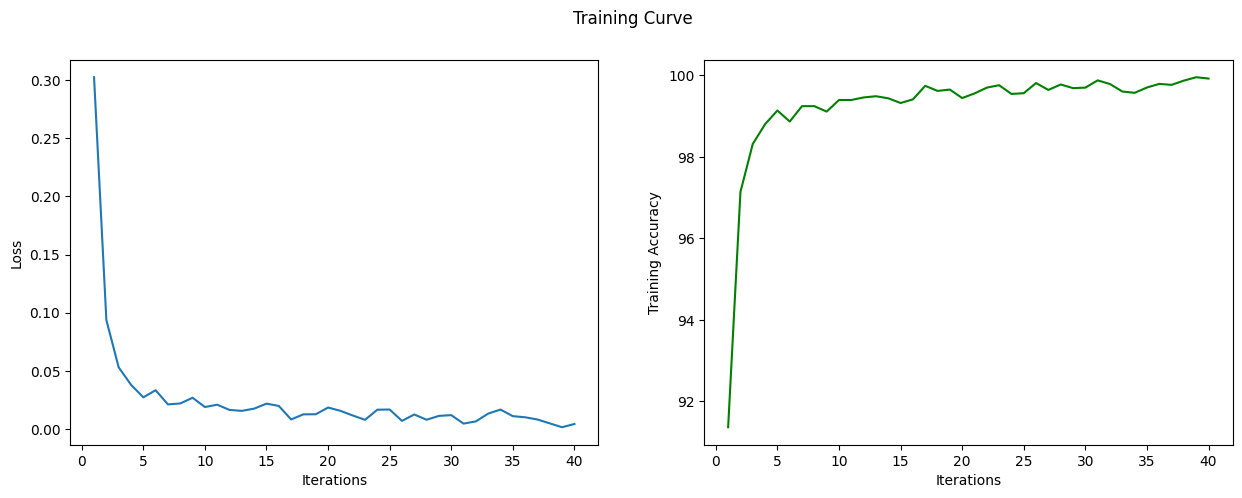

In [43]:
train_curves(epochs, train_losses, train_accuracies)

In [44]:
# set net in test (evaluation) mode
net.eval()  

# get predictions for test data
test_predictions = net(test_tensor)

# to get class with the maximum score as prediction
_, test_predicted = torch.max(test_predictions.data,1)

# Save results in the required format
output = pd.DataFrame({'ImageId': test.index + 1,
                       'Label': test_predicted})
output.to_csv('submission.csv', index=False)
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
